In [8]:
from modules import node, sensing, system
from modules import optimization as opt
from configs import config

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, qr

noise_power = config.NOISE_POWER

In [9]:
tx = node.TX(x=0, y=0, z=10)
rx = node.RX(x=50, y=50, z=1.5)
ris = node.RIS(x=10, y=50, z=2, N=5)

sys = system.System(tx, ris, rx)

# generate a channel h
sys.gen_channels(is_los=True)

# sending samples and collect observation:
N_samples = 10000
X = np.zeros(shape=(sys.ris.N, N_samples))
y = np.zeros(shape=(N_samples, 1))

for i in range(N_samples):
    # generate a random ris setting
    sys.ris.set_random_binary_phase_shifts()
    x = sys.ris.vector_x
    X[:, i] = x.flatten()
    y[i] = sys.cal_snr() - sys.c_true

In [10]:
def cal_errors(n, T=50):
    d = ris.N
    k = 2
            
    def compute_A(X, M):
        # A_i(M) = x_i.T @ M @ x_i
        # shape of X: d x n
        # A(M) should be a column vector, shape n x 1
        n = X.shape[1]
        return np.array([X[:, i].T @ M @ X[:, i] for i in range(n)]).reshape(-1, 1)

    def compute_A_adj(z, X):
        # compute adjoint operator = 1/2/n * sum (z_i * x_i * x_i.T)
        # z is a column vector
        # return a matrix whose shape d x d
        n = X.shape[1]
        sum = 0
        for i in range(n):
            sum += z[i, 0] * X[:, i].reshape(-1, 1) @ X[:, i].reshape(-1, 1).T
        return sum
    
    # Initialization using the first mini batch
    w = np.zeros((d, 1))
    V = np.zeros((d, k))
    X_init = X[:, :n]
    y_init = y[:n]
    M_init = np.zeros((d, d))
    A_M_init = compute_A(X=X_init, M=M_init)
    r = y_init - A_M_init - X_init.T @ w
    H1_init = compute_A_adj(r, X_init)
    h2_init = np.mean(r)
    matrix_init = H1_init - 0.5 * h2_init * np.eye(d)
    U_init, _, _ = svd(matrix_init)
    U = U_init[:, :k]

    all_norms = [] # store the norm of M + the norm of w, to confirm convergence
    i = 0
    # compute each mini-batch
    while True:
        # current batch data
        start = i * n
        end = start + n
        X_t = X[:, start:end]
        y_t = y[start:end]
        
        # this is the current M computed using U and V from previous batch
        M = 0.5 * (U @ V.T + V @ U.T)
        
        A_M = compute_A(X=X_t, M=M)
        r_t = y_t - A_M - X_t.T @ w

        H1 = 1/2/n * compute_A_adj(z=r_t, X=X_t)
        h2 = np.mean(r_t)
        h3 = 1/n * X_t @ r_t

        matrix_update = H1 - 0.5 * h2 * np.eye(d) + M.T
        U_hat = matrix_update @ U
        U, _ = qr(U_hat, mode='economic')

        w = w + h3
        V = matrix_update @ U

        # store the sum of norm
        all_norms.append(np.linalg.norm(M - sys.M_true) + np.linalg.norm(w - sys.w_true))
        i += 1
        if i == T:
            break
    
    return all_norms

In [11]:
all_norms_10 = cal_errors(n=10, T=20)
all_norms_20 = cal_errors(n=20, T=20)
all_norms_50 = cal_errors(n=50, T=20)
all_norms_100 = cal_errors(n=100, T=20)

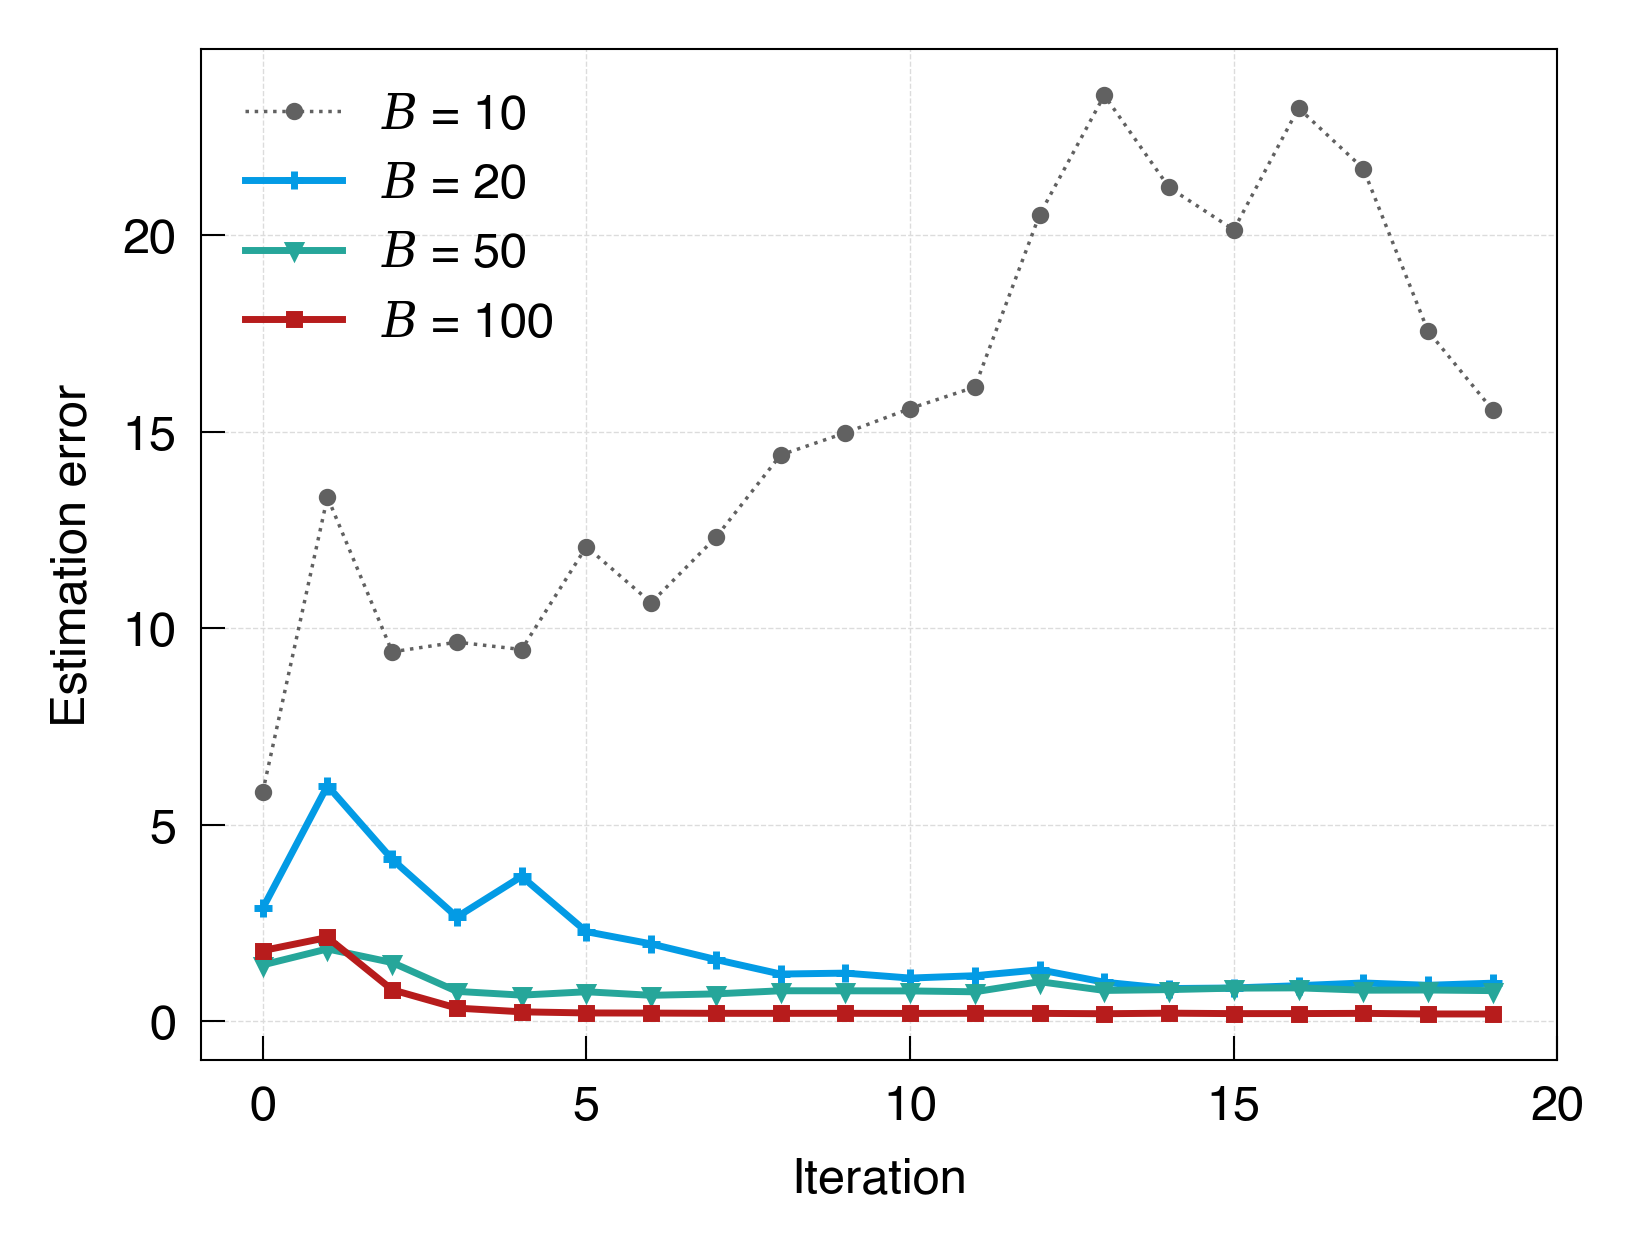

In [30]:

colors = ['#B71C1C', '#039BE5', '#26A69A', '#FF6F00', '#616161', '#BA68C8', '#EC407A']
plt.figure(figsize=(3.5, 2.625), dpi=500)

# Font setup
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 7
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['ytick.minor.visible'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['ytick.major.width'] = 0.3
plt.rcParams['axes.linewidth'] = 0.3

# Top plot
plt.plot(all_norms_10, color=colors[4],  marker='o', markersize=1.5, lw=0.5, label=r'$B$ = 10', ls=':')
plt.plot(all_norms_20, color=colors[1],  marker='+', markersize=2.5, lw=1, label=r'$B$ = 20')
plt.plot(all_norms_50, color=colors[2],  marker='v', markersize=1.5, lw=1, label=r'$B$ = 50')
plt.plot(all_norms_100, color=colors[0],  marker='s', markersize=1.5, lw=1, label=r'$B$ = 100')
plt.xticks([0, 5, 10, 15, 20])
plt.xlabel('Iteration')
plt.ylabel('Estimation error')
leg = plt.legend(frameon=False, edgecolor='black', framealpha=0.6)
leg.get_frame().set_linewidth(0.4)
plt.grid(color='gainsboro', linestyle='--', linewidth=0.2)
plt.savefig('fig_convergence_N5_LOS.pdf', dpi=500, bbox_inches='tight', pad_inches=0.05)